In [257]:
%matplotlib inline
import torch
import fairseq
import faiss
import subprocess
import numpy as np
import pandas as pd
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [258]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
from sparse_prototype.sp_model import TemplateModel

In [260]:
model_dir = 'checkpoint/cocov/20201201/cocov_adam_noeditvec_alpha0.01_kappa30_ns10_editdim10_rtrprecompute_emb_fr0.8_dr1_rf0.03_fb0_embtvemb_lc1_uf2_gpu1_2_csp_elbo'

In [261]:
cocov_model = TemplateModel.from_pretrained(
    model_dir,
    checkpoint_file='checkpoint_best.pt',
    data_name_or_path='data-bin/cocov',
)

cocov_model.eval()
cocov_model.cuda(device=0)

| [None] dictionary: 11168 types
| [edit] dictionary: 8 types
KLD: 6.117159366607666
read template embeddings complete!


TemplateHubInterface(
  (models): ModuleList(
    (0): TemplateModel(
      (classifier): PrecomputeEmbedRetriever(
        (linear1): Linear(in_features=1024, out_features=1024, bias=False)
        (middle): Sequential()
        (linear2): Linear(in_features=1024, out_features=39557, bias=False)
      )
      (classifier_ahead): PrecomputeEmbedRetriever(
        (linear1): Linear(in_features=1024, out_features=1024, bias=False)
        (middle): Sequential()
        (linear2): Linear(in_features=1024, out_features=39557, bias=False)
      )
      (editor): FairseqEncoderDecoderModel(
        (encoder): LSTMEncoder(
          (embed_tokens): Embedding(11168, 300, padding_idx=1)
          (lstm): LSTM(300, 256, num_layers=3, dropout=0.3, bidirectional=True)
        )
        (decoder): LSTMLatentDecoder(
          (embed_tokens): Embedding(11168, 300, padding_idx=1)
          (encoder_hidden_proj): Linear(in_features=562, out_features=256, bias=True)
          (encoder_cell_proj): Linea

In [262]:
def get_active_templates(model):
    res = []
    lambda_ = model.models[0].lambda_
        
    prob = lambda_ / lambda_.sum()
    sorted_prob, indices = torch.sort(prob, descending=True)
    sum_ = 0.

    for prob_i, id_i in zip(sorted_prob, indices):
        sum_ += prob_i.item()
        res.append(id_i.item())
        if sum_ >= 0.9:
            break

    return res

In [10]:
active_template_ids = get_active_templates(cocov_model)
print(active_template_ids[:100])

[266, 29019, 8972, 18387, 26525, 3970, 16416, 23473, 33058, 11174, 12763, 7794, 7170, 16370, 37767, 7672, 37199, 21549, 24829, 29299, 789, 11159, 20414, 3627, 21117, 17421, 16701, 36052, 21576, 17143, 39358, 39264, 29396, 1977, 4119, 14528, 7474, 4521, 32733, 32812, 240, 37998, 36892, 37548, 11591, 4761, 30677, 35797, 4098, 21554, 20154, 28010, 7688, 10238, 30183, 30030, 28337, 11090, 29036, 31197, 25053, 37818, 23547, 24886, 24501, 17313, 11215, 8045, 2300, 33212, 35572, 18307, 25129, 38457, 34504, 24409, 17733, 34166, 23598, 22501, 27630, 7707, 21137, 11742, 28133, 35651, 12748, 23675, 3619, 5217, 26742, 29816, 1029, 9134, 22192, 39001, 824, 28966, 2710, 8529]


In [11]:
len(active_template_ids)

18032

In [13]:
def get_kmeans_cluster(template_ids, ncentroids=200, niter=20, verbose=True):
    def get_file_len(file):
        proc = subprocess.run(['wc', '-l', file], capture_output=True)
        return int(proc.stdout.decode('utf-8').split()[0])
    
    example_size = get_file_len('datasets/cocov/template.txt')
    vemb = np.memmap('precompute_embedding_datasets/cocov/cocov.vemb.template.npy', 
        dtype='float32', mode='r', shape=(example_size, 1024))
    vemb = vemb[template_ids]
    
    d = vemb.shape[1]
    kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
    kmeans.train(vemb)
    D, I = kmeans.index.search(vemb, 1)
    
    id2cluster = {}
    for id_, i_cluster in zip(template_ids, I):
        id2cluster[id_] = i_cluster[0]
    
    cluster2id = {}
    for id_, i_cluster in id2cluster.items():
        if i_cluster in cluster2id:
            cluster2id[i_cluster].append(id_)
        else:
            cluster2id[i_cluster] = [id_]
            
    return id2cluster, cluster2id
               

In [14]:
id2cluster, cluster2id = get_kmeans_cluster(active_template_ids, ncentroids=50)

In [15]:
print(cluster2id[20][:20])

[10413, 37536, 34097, 35333, 26458, 16151, 3123, 30428, 4614, 24292, 325, 21945, 31927, 22668, 12856, 26965, 17172, 28991, 9172, 22295]


In [16]:
template_imageids = open('datasets/cocov/template.id').readlines()
template_text = open('datasets/cocov/template.txt').readlines()

In [17]:
template_imageids[0]

'COCO_train2014_000000332299#2\n'

In [18]:
def get_image_file(id_, template_imageids):
    image_id = template_imageids[id_].split('#')[0]
    
    return f'cocov_images/{image_id}.jpg'

In [19]:
def plot_cluster(ids, template_text, template_imageids):
    plotids = np.random.choice(ids, 8, replace=False)
    nrow = 2
    ncol = 4
    fig, axs = plt.subplots(nrow, ncol, figsize=(20, 6))
    cnt = 0
    for i in range(nrow):
        for j in range(ncol):
            image = get_image_file(plotids[cnt], template_imageids)
            text = template_text[plotids[cnt]].strip()
            
            img = mpimg.imread(image)
            axs[i, j].imshow(img)
            axs[i, j].set(xlabel=text)
            cnt+=1

In [223]:
def sample_from_cluster(ids, model, template_text, nsample=20, gen_args=None):
    sample_ids = np.random.choice(ids, nsample, replace=True)
    templates = [template_text[x].strip() for x in sample_ids]
    inference_args = {'mode': 'gen_sample'}
#     gen_args = {'sampling': True, 'sampling_topk': 50}
    gen_args = {} if gen_args is None else gen_args
    hypos = model.sample(templates, inference_step_args=inference_args, **gen_args)
    pd_data = pd.DataFrame(data={'generation': hypos})
#     dfStyler = pd_data.style.set_properties(**{'text-align': 'left'})
#     dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    
    def left_align(df):
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
            [dict(selector='th', props=[('text-align', 'left')])]
        )
        return left_aligned_df
    
    with pd.option_context('display.max_rows', None, 
                           'display.max_columns', None, 
                           "display.max_colwidth", -1):
        display(left_align(pd_data))

A dog looking onward with it 's mouth open .

COCO_train2014_000000110928#3



,generation
0,A dog is sitting in a chair looking at his reflection .
1,A dog looking out the window of a car window .
2,A dog is sitting on a couch with a dog .
3,A person is walking down a street with a dog .
4,A couple of dogs sitting on a couch with a dog .
5,A white dog sitting on top of a couch .
6,The man is sitting in the chair with his dog .
7,A dog is looking at a dog in the water .
8,A dog laying on a couch with a dog .
9,A dog is sitting on a couch with a dog .


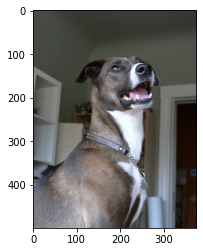

In [62]:
id_ = active_template_ids[22]
print(template_text[id_])
print(template_imageids[id_])
image = get_image_file(id_, template_imageids)
img = mpimg.imread(image)
plt.imshow(img)

sample_from_cluster([id_], cocov_model, template_text, nsample=20)

In [128]:
# show datastore images/text
# datastore4: zebra
# datastore8: cat
# datastore14: dog
# datastore34: elephant
# datastore20: bird
# datastore23: giraffe
# datastore44: horse
# datastore47,48: sheep,bear
# datastore9: food
# datastore28: food
# datastore41: pizza
# datastore10: eating food
# datastore18: skateboard
# datastore19: tennis
# datastore24: frisbee
# datastore27: tennis
# datastore30: ski
# datastore39: sport
# datastore46: baseball

# datastore_electronic = cluster2id[33]
datastore_sport = cluster2id[18] +  cluster2id[19] + cluster2id[24] + cluster2id[27] + cluster2id[30] + cluster2id[39] + cluster2id[46]
datastore_animal = cluster2id[4] + cluster2id[8] + cluster2id[14] + cluster2id[34] + cluster2id[20] + cluster2id[23] + cluster2id[44] \
    + cluster2id[47] + cluster2id[48]
datastore_food = cluster2id[9] + cluster2id[28] +cluster2id[41] +cluster2id[10]

# MSCOCO Demo Starts Here
#### We prepared three different datastores separated by visual topics, first we show sampled templates in the datastore, then we randomly generate 20 examples from the model using the datastore

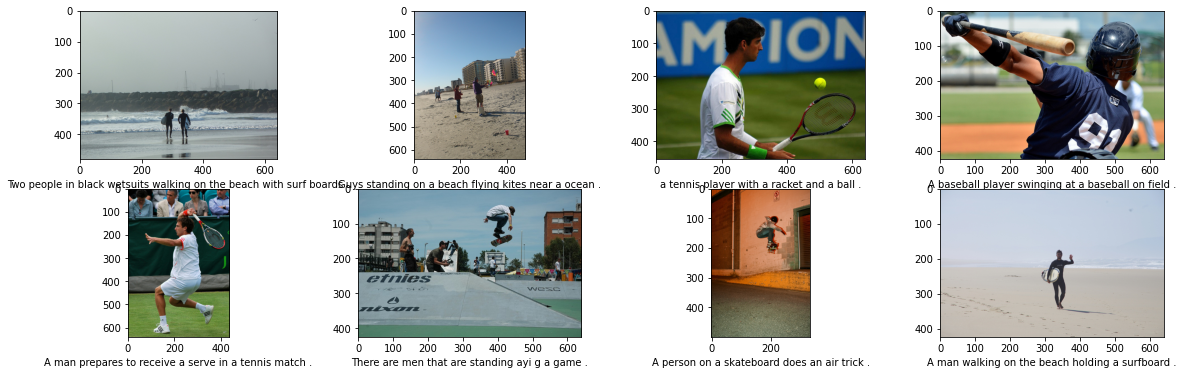

In [451]:
# show datastore images/text
datastore = datastore_sport
# datastore = datastore_animal
# datastore = datastore_food

# showing 8 sampled templatets along with images in the datastore
plot_cluster(datastore, template_text, template_imageids)

In [454]:
torch.manual_seed(0)
np.random.seed(0)
sample_from_cluster(datastore, cocov_model, template_text, nsample=20)

,generation
0,The batter is getting ready to throw the ball .
1,A woman in black jacket skiing down a snowy slope .
2,There is a man walking on the beach with a surfboard .
3,A girl in the ocean holding a surfboard .
4,A woman standing on top of a snow covered slope .
5,A man standing in front of a surfboard in the water .
6,Two people are riding surfboards on the ocean .
7,A man in black jacket and a hat on skis .
8,A man standing next to a snow covered slope .
9,A batter throwing a ball with a baseball bat .


In [131]:
seedling_model_dir = 'checkpoint/seedling/20201201/seedling_adam_noeditvec_alpha0.3_kappa30_ns10_editdim10_rtrprecompute_emb_fr0.8_dr1_rf0.3_fb6_embtbert_lc0_0_2500_1_uf4_gpu3_csp_elbo'

In [138]:
seedling_model = TemplateModel.from_pretrained(
    seeding_model_dir,
    checkpoint_file='checkpoint_best.pt',
    data_name_or_path='data-bin/seedling',
)

seedling_model.eval()
seedling_model.cuda(device=0)

| [None] dictionary: 13120 types
| [edit] dictionary: 8 types
KLD: 6.117159366607666
read template embeddings complete!


TemplateHubInterface(
  (models): ModuleList(
    (0): TemplateModel(
      (classifier): PrecomputeEmbedRetriever(
        (linear1): Linear(in_features=768, out_features=768, bias=False)
        (middle): Sequential()
        (linear2): Linear(in_features=768, out_features=55198, bias=False)
      )
      (classifier_ahead): PrecomputeEmbedRetriever(
        (linear1): Linear(in_features=768, out_features=768, bias=False)
        (middle): Sequential()
        (linear2): Linear(in_features=768, out_features=55198, bias=False)
      )
      (editor): FairseqEncoderDecoderModel(
        (encoder): LSTMEncoder(
          (embed_tokens): Embedding(13120, 300, padding_idx=1)
          (lstm): LSTM(300, 256, num_layers=3, dropout=0.3, bidirectional=True)
        )
        (decoder): LSTMLatentDecoder(
          (embed_tokens): Embedding(13120, 300, padding_idx=1)
          (encoder_hidden_proj): Linear(in_features=562, out_features=256, bias=True)
          (encoder_cell_proj): Linear(in_f

In [139]:
seedling_active_template_ids = get_active_templates(seedling_model)
print(len(seedling_active_template_ids))

27124


In [140]:
seedling_template_text = open('datasets/seedling/template.txt').readlines()

In [171]:
def get_len_cluster(template_ids, template_text, nbucket=10, bound=None):
    def get_bound_id(x, bound):
        for i, (s, e) in enumerate(bound):
            if x >= s and x < e:
                return i
        
        raise ValueError
        
    lengths = []
    for i in template_ids:
        lengths.append(len(template_text[i].strip().split()))
    sorted_lengths = sorted(lengths)
    interval = len(template_ids) // nbucket
    if bound is None:
        bound = []
        for i in range(nbucket):
            if i == 0:
                bound.append((0, sorted_lengths[interval]))
            elif i == nbucket - 1:
                bound.append((sorted_lengths[i * interval], 1e3))
            else:
                bound.append((sorted_lengths[i * interval], sorted_lengths[(i+1) * interval]))
    print(bound)
    cluster2id = {}
    for id_ in template_ids:
        len_ = len(template_text[id_].strip().split())
        bound_id = get_bound_id(len_, bound)
        if bound_id in cluster2id:
            cluster2id[bound_id].append(id_)
        else:
            cluster2id[bound_id] = [id_]
    
    return cluster2id

In [238]:
seedling_cluster2id = get_len_cluster(seedling_active_template_ids, 
                                      seedling_template_text,
                                      bound=[(0,5), (5, 15), (15, 30), (30,50), (50,1000)])

[(0, 5), (5, 15), (15, 30), (30, 50), (50, 1000)]


In [239]:
seedling_cluster2id[3][:10]

[29094, 45135, 35849, 21764, 23497, 32405, 33343, 3748, 8810, 50411]

In [180]:
seedling_template_text[29094]

'was bedtime so five little monkeys took about five little monkeys put on there for jama five little monkeys brush their teeth little monkey figure a night to their mama\n'

In [225]:
def display_template(datastore, template_text, nsample=10):
    sample_ids = np.random.choice(datastore, nsample, replace=False)
    templates = [template_text[x].strip() for x in sample_ids]    
    pd_data = pd.DataFrame(data={'templates': templates})
    def left_align(df):
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
            [dict(selector='th', props=[('text-align', 'left')])]
        )
        return left_aligned_df
    with pd.option_context('display.max_rows', None, 
                           'display.max_columns', None, 
                           "display.max_colwidth", -1,
                           'display.colheader_justify', 'right',):
        display(left_align(pd_data)) 

# Seedling Demo Starts Here
#### We prepared three different datastores separated by complexity, first we show sampled templates in the datastore, then we randomly generate 20 examples from the model using the datastore

#### datastores in terms of lengths:

In [452]:
seedling_datastore = seedling_cluster2id[0]
# seedling_datastore = seedling_cluster2id[1]
# seedling_datastore = seedling_cluster2id[2]
display_template(seedling_datastore, seedling_template_text, nsample=10)

,templates
0,a book
1,he done now
2,everything tastes
3,croon was march
4,uh-oh
5,you know school play
6,that's a beautiful tiffany
7,goes right there
8,well i know
9,costume


In [453]:
torch.manual_seed(1)
np.random.seed(1)
sample_from_cluster(seedling_datastore, seedling_model, seedling_template_text, nsample=20, gen_args={'no_repeat_ngram_size': 3})

,generation
0,run run run
1,you can't put it on
2,do it
3,you all done all done
4,recording
5,cold
6,now
7,still your hands
8,o- o-
9,can you find a different


In [286]:
def get_age_cluster(template_ids, template_ages, cluster):
    def get_cluster_id(x, cluster):
        for i in cluster:
            if x in i:
                return i
        return -1
    
    cluster2id = {}
    for id_ in template_ids:
        cluster_id = get_cluster_id(template_ages[id_].strip(), cluster)
        if cluster_id == -1:
            continue
        
        if cluster_id in cluster2id:
            cluster2id[cluster_id].append(id_)
        else:
            cluster2id[cluster_id] = [id_]
            
    return cluster2id

In [275]:
seedling_active_templates = set()
for id_ in seedling_active_template_ids:
    seedling_active_templates.update(seedling_template_text[id_].strip())
    
seedling_age_template_text = open('datasets/seedling/template_new.txt').readlines()
seedling_age_template_age = open('datasets/seedling/template_new.age').readlines()

In [287]:
age_datastores = get_age_cluster(seedling_active_template_ids, seedling_age_template_age, 
                                 [('06', '07'), ('11', '12'), ('16', '17')])

In [290]:
age_datastores[('16', '17')][:10]

[48217, 19755, 30021, 14268, 39009, 23357, 7301, 8928, 51527, 16239]

#### datastores in terms of different ages:

In [435]:
torch.manual_seed(42)
np.random.seed(42)

seedling_age_datastore = age_datastores[('06', '07')]
# seedling_age_datastore = age_datastores[('16', '17')]
# seedling_age_datastore = age_datastores[('11', '12')]

display_template(seedling_age_datastore, seedling_age_template_text, nsample=10)

,templates
0,a little bit softer and won't hurt me so
1,power
2,they gave you a letter what does it say you
3,a whoa
4,12 right here is still okay
5,she describes for this is not the case in order to get paid very slightly different when it came in order i felt she was definitely not they are the same exact you're pushing them raise it was the first time you saw what you said something
6,toes and
7,foot
8,with the light duty you know you were to compare it and quality of life versus lady but would you say pretty apparently
9,sweetie you care about what she's doing good sitting here


In [433]:
sample_from_cluster(seedling_age_datastore, seedling_model, seedling_age_template_text, nsample=20, gen_args={'no_repeat_ngram_size': 3})

,generation
0,do you think the buttons are on the side
1,he was a little bit of a little while you were going to be
2,going to put it on your feet so much more than you can get a little bit
3,so i got to see what you're doing well i think you're going to be a little bit of a little while
4,here come here
5,god we can't go outside and play with the
6,this guy was going to be a little bit more than you know
7,he has a little
8,funny
9,could be a
